In [106]:
from pathlib import Path

import torch
from torch import Tensor
import matplotlib.pyplot as plt
from einops import rearrange
from torchvision.utils import save_image
from torch.nn.functional import normalize, softmax
from torchvision.transforms.functional import resize, rgb_to_grayscale

from src.dataset import VoiceToFaceDataset
from src.model.eigenface import Eigenface
from src.model.mlp import MLP
from src.model.voice_embedder import forge_voice_embedder_with_parameters, DEFAULT_OUTPUT_FEATURE_NUM
from src.model.generator import forge_generator_with_parameters
from src.config import TrainingConfig
from src.utils import get_tensor_device

In [2]:
device = get_tensor_device()

# Reconstructing Face from Voice using Eigenface

## Constructing dataset

In [3]:
test_dataset = VoiceToFaceDataset(
    Path('datasets/voices/'),
    Path('datasets/images/'),
    Path('datasets/metadata-test.csv'),
)

Creating dataset from datasets/metadata-test.csv.


Loading dataset...: 100%|██████████| 124/124 [00:01<00:00, 103.61it/s]


In [4]:
len(test_dataset)

14345

## Constructing Models and Load Checkpoints

In [5]:
# TARGET_PATH = Path('checkpoints/training/2022-12-9-15-31-52')
# TARGET_EPOCH = 12
TARGET_PATH = Path('checkpoints/training/2022-12-9-2-15-21')
TARGET_EPOCH = 25

training_config = TrainingConfig.from_json(TARGET_PATH / 'config.json')

In [6]:
voice_embedder = forge_voice_embedder_with_parameters(
    Path('checkpoints/voice_embedding.pth')
).to(device).eval()
generator = forge_generator_with_parameters(
    Path('checkpoints/generator.pth')
).to(device).eval()
eigenface_converter = Eigenface(Path('checkpoints/input-15k-pc-5k.npy')).to(device)
mlp = MLP(
    DEFAULT_OUTPUT_FEATURE_NUM,
    eigenface_converter.eigenface_components,
    training_config.mlp_hidden_size,
    training_config.mlp_hidder_layer_num,
    training_config.mlp_dropout_probability,
).to(device).eval()
mlp.load_state_dict(
    torch.load(TARGET_PATH / f'mlp-{TARGET_EPOCH}.pth', map_location=device)
)

Initializing Eigenface converter with eigenface_components = 5000.


## Compare Reconstructions and Ground-truths

Try the following:
[9087, 4728, 4328]

In [150]:
TRY_INDEX = 9087
voice_feature, voice_id, ground_truth_images, name = test_dataset[TRY_INDEX]
voice_feature = voice_feature.to(device)

In [151]:
# voice_feature = torch.randn(voice_feature.size()).to(device)

In [152]:
with torch.no_grad():
    voice_embedding = voice_embedder(voice_feature.unsqueeze(0))
    eigenface = mlp(rearrange(voice_embedding, 'N C 1 1 -> N C'))
    reconstructed_face = eigenface_converter.eigenface_to_face(eigenface).reshape(128, 128)
    reconstructed_face = reconstructed_face.detach().cpu()

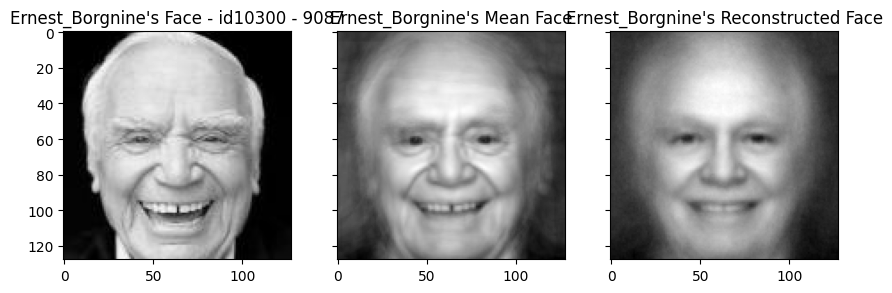

In [153]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 3))

a_ground_truth_image = ground_truth_images[10, :].reshape(128, 128).numpy()
ax1.imshow(a_ground_truth_image, cmap='gray')
ax1.set_title(f'{name}\'s Face - {voice_id} - {TRY_INDEX}')

mean_ground_truth_image = ground_truth_images.mean(dim=0).reshape(128, 128).numpy()
ax2.imshow(mean_ground_truth_image, cmap='gray')
ax2.set_title(f'{name}\'s Mean Face')

ax3.imshow(reconstructed_face.numpy(), cmap='gray')
ax3.set_title(f'{name}\'s Reconstructed Face')
fig.show()

## Yan et. al.'s Reconstruction

In [26]:
with torch.inference_mode():
    yan_reconstructed_face: Tensor = generator(voice_embedding)
    yan_reconstructed_face = yan_reconstructed_face.detach().cpu()

## Save Results

In [27]:
TARGET_RESULT_DIR = TARGET_PATH / f'result-{TARGET_EPOCH}'
TARGET_RESULT_DIR.mkdir(exist_ok=True)

In [28]:
fig.savefig(str(TARGET_RESULT_DIR / f'{name}-{TRY_INDEX}.png'))

In [29]:
save_image(
    rgb_to_grayscale(yan_reconstructed_face),
    TARGET_RESULT_DIR / f'{name}-{TRY_INDEX}-yan-reconstructed.png',
    normalize=True,
)

In [30]:
save_image(
    resize(reconstructed_face.unsqueeze(0), [64, 64]),
    TARGET_RESULT_DIR / f'{name}-{TRY_INDEX}-reconstructed.png',
    normalize=True,
)